# HOG visualizations

In [3]:
from skimage.feature import hog
%matplotlib inline

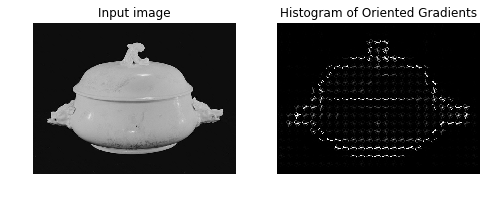

In [22]:
# find one example
import matplotlib.pyplot as plt
import cv2

from skimage.feature import hog
from skimage import data, exposure


# image = data.astronaut()
image = cv2.imread("/mnt/disks/large/debug_data/test/1018a55fce131346.png")

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(3, 3), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

# ROC-AUC for baseline & baseline+HOG

In [20]:
train_dir = "/mnt/disks/large/data/original_train/"
data_dir = "/mnt/disks/large/data/"
output_dir = "/home/rugezhao/CS231N_CZT/data/"

In [21]:
import pandas as pd
train_df = pd.read_csv(data_dir+"train.csv", engine='python')
labels_df = pd.read_csv(data_dir+"labels.csv", engine='python')


In [78]:
proportion = pd.read_csv("/home/rugezhao/CS231N_CZT/data/train_train_label_proportion.csv")

In [94]:
sorted_prop = proportion.sort_values(by='proportion',ascending=False)
top10_label = sorted_prop['proportion'][:10]
top10_label = list(top10_label.index)

In [8]:
# load truth

# dev
dev_ground_truth = pd.read_csv("/mnt/disks/large/data/train_split/train_split_val.csv")

# test
test_ground_truth = pd.read_csv("/mnt/disks/large/data/train_split/train_split_test.csv")

In [24]:
def convert_one_hot(train_df):
    train_id_attribute_id_ohe= np.zeros((len(train_df), len(labels_df)), dtype=int)
    for idx, attr_arr in enumerate(train_df.attribute_ids.str.split(" ").apply(lambda l: list(map(int, l))).values):
        train_id_attribute_id_ohe[idx, attr_arr] = 1
    train_id_attribute_id_ohe = pd.DataFrame(train_id_attribute_id_ohe,columns=labels_df.attribute_id)
    print(f"one hot encoding done, shape {train_id_attribute_id_ohe.shape}")
    
    return train_id_attribute_id_ohe
    

In [25]:
dev_ground_truth_ohe = convert_one_hot(dev_ground_truth)
test_ground_truth_ohe = convert_one_hot(test_ground_truth)

one hot encoding done, shape (10920, 1103)
one hot encoding done, shape (10920, 1103)


In [121]:
baseline_dev_pred = pd.read_csv("/mnt/disks/large/output/baseline_final/test/test-01/dev_prediction_raw_prob.csv")
baseline_test_pred = pd.read_csv("/mnt/disks/large/output/baseline_final/test/test-02/test_prediction_raw_prob.csv")

In [73]:
baseline_hog_dev_pred = pd.read_csv("/mnt/disks/large/output/baseline_hog_threshold_search_prop/test/test-47/dev_prediction_raw_prob.csv")
baseline_hog_test_pred = pd.read_csv("/mnt/disks/large/output/baseline_hog_threshold_search_prop/test/test-46/test_prediction_raw_prob.csv")

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


In [118]:
def ROC_multiclass_multilabel(y_score, y_test):
# Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_score.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    lw = 2

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in top10_label]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in top10_label:
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

#     remove macro as it does not make sense in 1103 classes 
#     plt.plot(fpr["macro"], tpr["macro"],
#              label='macro-average ROC curve (area = {0:0.2f})'
#                    ''.format(roc_auc["macro"]),
#              color='navy', linestyle=':', linewidth=4)

    colors = cycle(['blueviolet', 'limegreen', 'darksalmon', 'cadetblue',
'lightgoldenrodyellow', 'chartreuse', 'papayawhip', 'steelblue', 'purple',
'green', 'lawngreen', 'blue', 'darkslategray', 'dodgerblue', 'indigo',
'saddlebrown', 'aquamarine', 'violet', 'lime', 'midnightblue', 'fuchsia',
'snow', 'burlywood', 'mistyrose', 'beige', 'orangered', 'darkviolet',
'mediumorchid', 'antiquewhite', 'lightblue', 'darkgrey', 'lightslategray',
'indianred', 'crimson', 'olive', 'lightsalmon', 'sandybrown', 'chocolate',
'goldenrod', 'white', 'gold', 'tan', 'plum', 'darkgreen', 'darkorange',
'palegoldenrod', 'powderblue', 'greenyellow', 'm', 'mediumvioletred', 'ivory',
'turquoise', 'cornflowerblue', 'aliceblue', 'seagreen'])
    for i, color in zip(top10_label, colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.legend(fontsize='small')
    plt.show()

## Baseline

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


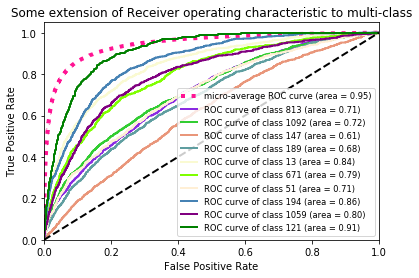

In [122]:
ROC_multiclass_multilabel(np.array(baseline_dev_pred), np.array(dev_ground_truth_ohe))

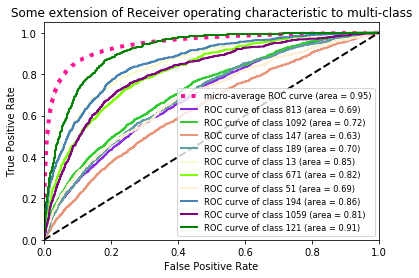

In [124]:
ROC_multiclass_multilabel(np.array(baseline_test_pred), np.array(test_ground_truth_ohe))

## Baseline + HOG

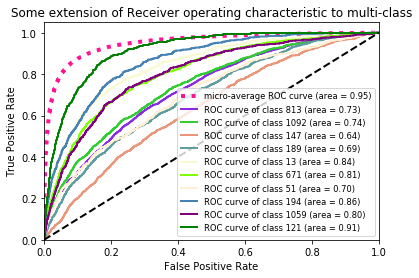

In [119]:
ROC_multiclass_multilabel(np.array(baseline_dev_pred), np.array(dev_ground_truth_ohe))

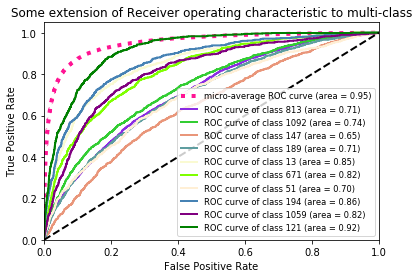

In [120]:
ROC_multiclass_multilabel(np.array(baseline_hog_test_pred), np.array(test_ground_truth_ohe))